In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
import warnings
import sys
import os
def nbipath():
    os.chdir('..')
    path = os.getcwd()+'/nbi'
    return path 

sys.path.insert(0, nbipath())
from nbi1 import *

from numpy.random import randn
from scipy.stats import anderson
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import scipy

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    

In [3]:
csv_file = "/Users/AkshayKale/Documents/github/data/nbi/06-20-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

In [4]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

In [5]:
df_anova.head()

,score,adt,adtt,precp,region,precipitation,lengthofspan,material,structuretype,maintainer,spanlength
5,0.600322,Very Light,Light,0.87,West,Very Low,16.2,7,2,1,Medium
14,-0.407231,Moderate,Light,0.94,West,Very Low,12.2,5,2,1,Medium
70,0.179531,Light,Light,0.87,West,Very Low,6.1,7,2,1,Very Low
204,0.636844,Light,Light,0.70,West,Very Low,8.0,7,2,1,Medium
308,-1.227671,Moderate,Light,0.70,West,Very Low,61.0,3,10,80,Very High


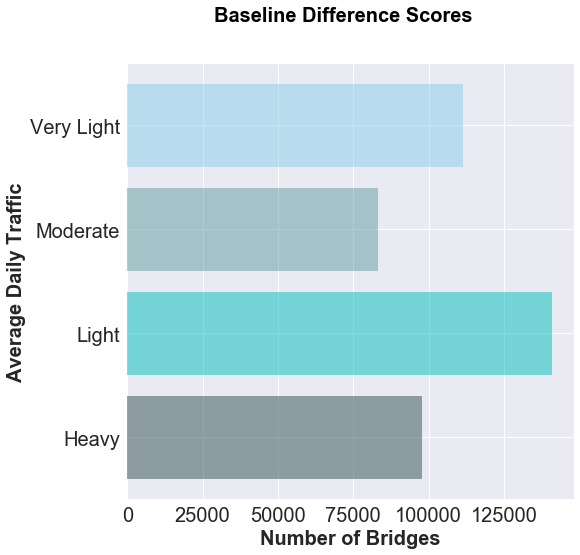

In [6]:
count_adt = df_anova.groupby('adt')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Light", "Light", "Moderate", "Heavy"]
no_of_records = [count_adt[3], count_adt[1], count_adt[2], count_adt[0]]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['skyblue','c','cadetblue','darkslategray'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Average Daily Traffic", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

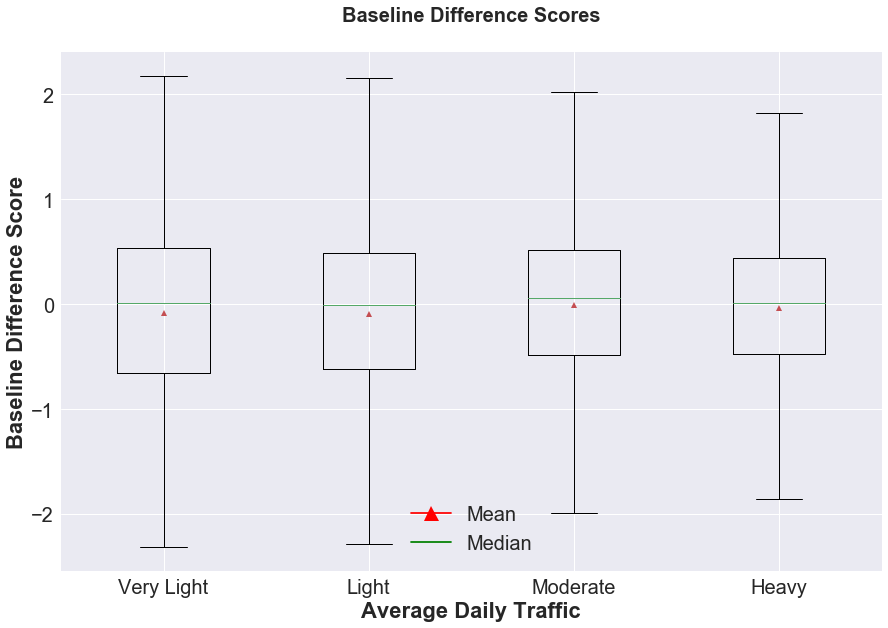

In [7]:
scores_verylight = df_anova[df_anova['adt'] == 'Very Light']['score']
scores_light = df_anova[df_anova['adt'] == 'Light']['score']
scores_moderate = df_anova[df_anova['adt'] == 'Moderate']['score']
scores_heavy = df_anova[df_anova['adt'] == 'Heavy']['score']

scores_adt = [scores_verylight, scores_light, scores_moderate, scores_heavy]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')




# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_adt, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Average Daily Traffic", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line])

plt.show()

#### ANOVA - Small Sample

In [8]:
adt = df_anova.groupby('adt').apply(lambda s: s.sample(100))['adt'].tolist()
score = df_anova.groupby('adt').apply(lambda s: s.sample(100))['score'].tolist()
df_adt_sample_100 = pd.DataFrame({'adt':adt, 'score':score})
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_adt_sample_100, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),3.565015,3.0,1.904095,0.128337,0.01422,0.006735
Residual,247.142014,396.0,NaN,NaN,NaN,NaN


### Cohen's d: 0.20 (Small)

#### ANOVA - Large Sample

In [9]:
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_anova, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),425.193256,3.0,219.999179,1.370711e-142,0.001975,0.001966
Residual,214813.588479,333440.0,NaN,NaN,NaN,NaN


### Cohen's d: 0.06 (Very Small)

### Results of Deck  

In [ ]:
csv_file = "/Users/AkshayKale/Documents/github/data/nbi/06-20-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

In [ ]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

In [14]:
df_anova.head()

,score,adt,adtt,precp,region,precipitation,lengthofspan,material,structuretype,maintainer,spanlength
5,0.600322,Very Light,Light,0.87,West,Very Low,16.2,7,2,1,Medium
14,-0.407231,Moderate,Light,0.94,West,Very Low,12.2,5,2,1,Medium
70,0.179531,Light,Light,0.87,West,Very Low,6.1,7,2,1,Very Low
204,0.636844,Light,Light,0.70,West,Very Low,8.0,7,2,1,Medium
308,-1.227671,Moderate,Light,0.70,West,Very Low,61.0,3,10,80,Very High


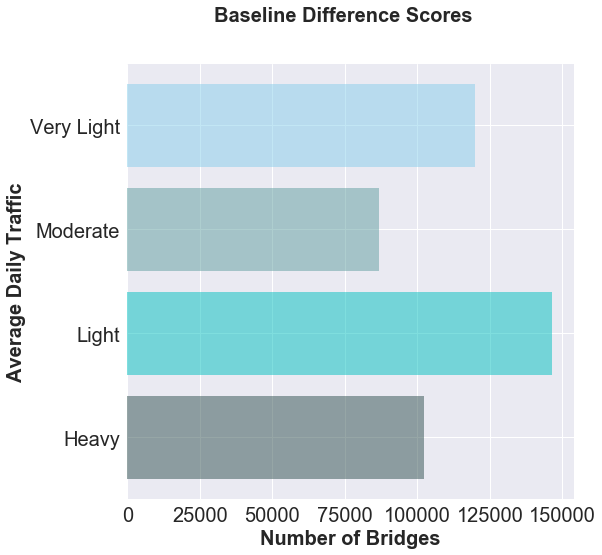

In [16]:
count_adt = df_anova.groupby('adt')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Light", "Light", "Moderate", "Heavy"]
no_of_records = [count_adt[3], count_adt[1], count_adt[2], count_adt[0]]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['skyblue','c','cadetblue','darkslategray'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Average Daily Traffic", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

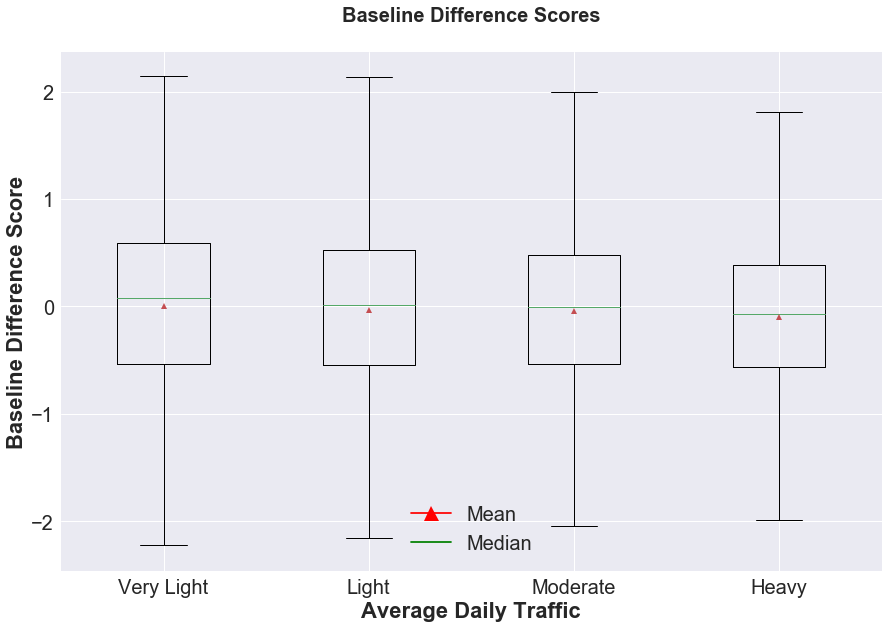

In [17]:
scores_verylight = df_anova[df_anova['adt'] == 'Very Light']['score']
scores_light = df_anova[df_anova['adt'] == 'Light']['score']
scores_moderate = df_anova[df_anova['adt'] == 'Moderate']['score']
scores_heavy = df_anova[df_anova['adt'] == 'Heavy']['score']

scores_adt = [scores_verylight, scores_light, scores_moderate, scores_heavy]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')




# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_adt, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Average Daily Traffic", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line])

plt.show()

### Small Sample

In [18]:
adt = df_anova.groupby('adt').apply(lambda s: s.sample(100))['adt'].tolist()
score = df_anova.groupby('adt').apply(lambda s: s.sample(100))['score'].tolist()
df_adt_sample_100 = pd.DataFrame({'adt':adt, 'score':score})
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_adt_sample_100, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),2.202305,3.0,1.074348,0.359786,0.008073,0.000557
Residual,270.586720,396.0,NaN,NaN,NaN,NaN


#### Cohen's d: 0.17 ( Very small)

### Large Sample 

In [19]:
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_anova, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),460.207472,3.0,249.304949,1.275836e-161,0.002147,0.002138
Residual,213900.235983,347624.0,NaN,NaN,NaN,NaN


#### Cohen's d: 0.08 (Very small)